# Set up 

In [1]:
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Library 

In [2]:
def barkbark(cloud,formants,formantchar='F'):
    newcloud=cloud.copy()
    for formant in formants:
        name = str(formant).replace(formantchar,'z')
        newcloud[name] = 26.81/ (1+ 1960/newcloud[formant]) - 0.53
    return newcloud

In [3]:
def activation(testset,cloud,dims = {'F0':4,'F1':2,'F2':3,'F3':1},c=0.01,rmspkr=True):
    # Get stuff ready                                                   
    dims.update((x, (y/sum(dims.values()))) for x, y in dims.items())   # Normalize weights to sum to 1
    
    # If the testset happens to have N in it, remove it before joining dfs 
    test=testset.copy()
    if 'N' in test.columns:
        test = test.drop(columns='N', axis=1,inplace=True)
    
    exemplars=cloud[~cloud.isin(test)].dropna()
    if rmspkr == True:
        spkr=test.speaker.iloc[0]
        spkrexemps=exemplars[ exemplars['speaker'] == spkr ].index
        exemplars.drop(spkrexemps, inplace=True)
        
    
    # Merge test and exemplars
    bigdf = pd.merge(
        test.assign(key=1),         # Add column named 'key' with all values == 1
        exemplars.assign(key=1),    # Add column named 'key' with all values == 1
        on='key',                   # Match on 'key' to get cross join (cartesian product)
        suffixes=['_t', '_ex']
    ).drop('key', axis=1)           # Drop 'key' column
    
    
    dimensions=list(dims.keys())                # Get dimensions from dictionary
    weights=list(dims.values())                 # Get weights from dictionary
    tcols = [f'{d}_t' for d in dimensions]      # Get names of all test columns
    excols = [f'{d}_ex' for d in dimensions]    # Get names of all exemplar columns
    
    
    # Multiply each dimension by weights
    i = bigdf.loc[:, tcols].values.astype(float)     # Get all the test columns
    i *= weights                                     # Multiply test columns by weight
    j = bigdf.loc[:, excols].values.astype(float)    # Get all the exemplar columns
    j *= weights                                     # Multiply exemplar columns by weights
    
    # Get Euclidean distance
    bigdf['dist'] = np.sqrt(np.sum((i-j)**2, axis=1))
    
    # get activation: exponent of negative distance * sensitivity c, multiplied by N_j
    bigdf['a'] = np.exp(-bigdf.dist*c)*bigdf.N
    
    return bigdf
    

In [4]:
def reset_N(exemplars, N=1):      # Add or override N, default to 1
    exemplars['N'] = N
    return exemplars

In [5]:
def probs(bigdf,cats):
    prs = {}
    for cat in cats: 
        label = cat+'_ex'
        cat_a = bigdf.groupby(label).a.sum()
        pr = cat_a/sum(cat_a)
        pr = pr.rename_axis(cat).reset_index().rename(columns={"a":"probability"})
        prs[cat]=pr
    return prs
    

In [6]:
def choose(pr,test,cats,runnerup=False):
    newtest = test.copy()

    for cat in cats:
        choicename = cat + 'Choice'
        choiceprobname = cat + 'Prob'
        
        best2 = pr[cat]['probability'].nlargest(n=2).reset_index(drop=True)        # Get the two highest probs for each cat type
        
        choiceprob = best2[0]                                                      # Match the prob to the category
        choice = pr[cat].loc[pr[cat]['probability']==choiceprob,cat].iloc[0]
        
        newtest[choicename] = choice
        newtest[choiceprobname] = choiceprob
        
        if runnerup == True: 
            choice2name = cat + 'Choice2'
            choice2probname = cat +'Choice2Prob'
            choice2prob = best2[1]                                                      
            choice2 = pr[cat].loc[pr[cat]['probability']==choice2prob,cat].iloc[0]
            newtest[choice2name] = choice2
            newtest[choice2probname] = choice2prob
            
    return newtest

In [7]:
def gettestset(cloud,balcat,n):     #Gets n number of rows per cat in given cattype
    testlist=[]
    for cat in list(cloud[balcat].unique()):
        samp = cloud[cloud[balcat]==cat].sample(n)
        testlist.append(samp)
    test=pd.concat(testlist)
    return test

In [8]:
def multicat(cloud,testset,cats,dims = {'F0':4,'F1':2,'F2':3,'F3':1},c=0.01):
    choicelist=[]
    for ix in list(testset.index.values):
        test = testset.loc[[ix,]]
        #exemplars=cloud[~cloud.isin(test)].dropna()
        exemplars=cloud.copy()
        reset_N(exemplars)
        bigdf=activation(test,exemplars,dims = dims,c=c)
        pr=probs(bigdf,cats)
        choices = choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist, ignore_index=True)
    return choices

In [9]:
def checkaccuracy(choices,cats):
    acc = choices.copy()                     # Make a copy of choices to muck around with
    
    for cat in cats:                     # Iterate over your list of cats
        accname = cat + 'Acc'            # Get the right column names
        choicename = cat + 'Choice'
        
        # If choice is the same as intended, acc =y, else n
        acc[accname] = np.where(acc[cat]==acc[choicename], 'y', 'n')      
    return acc

In [10]:
def propcorr(acc,cat):
    perc = dict(acc.groupby(cat)[cat+'Acc'].value_counts(normalize=True).drop(labels='n',level=1).reset_index(level=1,drop=True))
    pc=pd.DataFrame.from_dict(perc, orient='index').reset_index()
    pc.columns=[cat,'propcorr']
    return pc

In [11]:
def overallacc(acc,cat):
    totalcorrect = acc[cat+'Acc'].value_counts(normalize=True)['y']
    return totalcorrect

In [12]:
def accplot(pc,cat,acc):
    obs=str(len(acc))
    pl = sns.barplot(x=cat,y='propcorr',data=pc,palette=colors)
    plt.ylim(0,1.01)
    pl.set(ylabel='Proportion accurate of '+obs+' trials')
    pl.set_xticklabels(
    pl.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
    plt.show()

In [13]:
def continuum (start,end,cloud,dimlist = ['F0','F1','F2','F3'],steps=7,df=False):
    vals = {}
    norms = {}
    rowlist = []
    
    st=cloud[cloud['vowel'] == start].sample().reset_index(drop=True) # randomly sample a row with the some start vowel
    spkr = st.speaker.iloc[0]                                         # Get the speaker and gender
    gen = st.gender.iloc[0]
    en=pb52[(cloud.speaker==spkr) & (cloud['vowel']==end)].sample().reset_index(drop=True)  # get a row with the end vowel from same speaker


    for dim in dimlist:                      # Calculate the difference between start and end for each dim
        norms[dim] = en[dim] - st[dim]                               

    for i in range (0,steps):
        for dim in dimlist: 
            vals[dim] = st[dim] + (norms[dim] * i/(steps-1))    # the values for each dim = start val + diff by step
            row = pd.DataFrame(vals)
            row['vowel'] = '?'
            row['speaker'] = spkr
            row['gender'] = gen
        rowlist.append(row)

    rowlist[0]['vowel'] = start                                   # Change start and end vowels
    rowlist[-1]['vowel'] = end
    cont=pd.concat(rowlist,ignore_index=True)             # concatenate

    if df == True:
        return cont
    else:
        return rowlist

In [14]:
def FCN(exemplars,start,end):
    exemplars['N'] = np.where((exemplars['vowel']==start)|(exemplars['vowel']==end), 1, 0)
    return exemplars

## Include other speaker characteristics 

In [15]:
def choosecontinuum(cont,cloud,cats,start,end,FC=False):
    exemplars=cloud.copy()
    exemplars=exemplars[~exemplars.isin(cont)].dropna()
    choicelist = []
    for row in cont: 
        test=row
        if FC == True:
            FCN(exemplars,start,end)
        else:
            reset_N(exemplars)
        bigdf=activation(test,exemplars)
        pr=probs(bigdf,cats)
        choices=choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist,ignore_index=True)
    return choices
        

In [16]:
def resonate(pr,rescats,cloud,beta=0.25,gamma=0.25):
    #beta slows influence of first guess down, gives chance to revise guess
    exemplars = cloud.copy()
    for cat in rescats:
        probval = exemplars[cat].map(pr[cat].set_index(cat).to_dict()['probability'])
        # change N to existing N + some prop of probability 
        exemplars['N'] = exemplars['N'] + (beta * probval) - (gamma * (1-probval))
    return exemplars
        

In [17]:
def multirescat(testset,dims,cloud,cats,c,ncycles,rescats,beta=0.25,gamma=0.25):
    choicelist=[]
    
    for ix in list(testset.index.values):
        #set the test and exemplar cloud for the trial
        test = testset.loc[[ix,]]
        exemplars=cloud[~cloud.isin(test)].dropna()
        reset_N(exemplars)
    
        #do the first categorization
        bigdf=activation(test,exemplars,dims = dims,c=c)
        pr=probs(bigdf,cats)
    
        #Start the resonance loop
        for cycle in range(0,ncycles):
            exemplars=resonate(pr,rescats,exemplars,beta=beta,gamma=gamma)
            bigdf=activation(test,exemplars,dims=dims,c=c)
            pr=probs(bigdf,cats)
    
        #Make a final categorization for that trial
        choices = choose(pr,test,cats)
        
        choicelist.append(choices)
    choices=pd.concat(choicelist, ignore_index=True)
    return choices

In [18]:
def rescat(test,exemplars,dims,cats,c,n_res,rescats,beta=0.25,gamma=0.25):
    reset_N(exemplars)
    for i in range(0,n_res):
        act = activation(test,exemplars,dims=dims,c=c)
        prob = probs (act,cats)
        exemplars = resonate(prob,rescats,exemplars,beta=beta,gamma=gamma)
    choices = choose(prob,test,cats)
    return choices

In [19]:
def multiaccplot(choices,cats):
    accuracy = checkaccuracy(choices,cats)
    for cat in cats:
        proportion = propcorr(accuracy,cat)
        accplot(proportion,cat,accuracy)
        print(proportion)

In [20]:
def errorfunc(x, cloud,testset,dimslist,catslist):
    #x = [c,F0,F1,F2,F3]
    c=x[0]
    dimsdict={dimslist[0]:x[1],dimslist[1]:x[2],dimslist[2]:x[3],dimslist[3]:x[4]}
    choices=multicat(cloud,testset,catslist,dims=dimsdict,c=c)
    accuracy=checkaccuracy(choices,catslist)
    err = accuracy['vowel'+'Acc'].value_counts(normalize=True)['n']
    return err

In [21]:
def errorfunc_c(x, cloud,testset,dimsdict,catslist):
    c=x[0]
    choices=multicat(cloud,testset,catslist,dims=dimsdict,c=c)
    accuracy=checkaccuracy(choices,catslist)
    err = accuracy['vowel'+'Acc'].value_counts(normalize=True)['n']
    return err

In [22]:
def errorfunc_anchor(x, cloud,testset,dimslist,catslist):
    #x = [c,F1,F2,F3]
    c=x[0]
    dimsdict={dimslist[0]:1,dimslist[1]:x[1],dimslist[2]:x[2],dimslist[3]:x[3]}
    choices=multicat(cloud,testset,catslist,dims=dimsdict,c=c)
    accuracy=checkaccuracy(choices,catslist)
    err = accuracy['vowel'+'Acc'].value_counts(normalize=True)['n']
    return err

In [23]:
def confusion(choices,cats):
    matrices={}
    for cat in cats:
        matrices[cat]=pd.crosstab(choices[cat],choices[cat+'Choice'],normalize='index').round(2).rename_axis(None)
    return matrices

In [24]:
def evalcycles(dictname,cats):
    accdict={}
    overallaccdict={}
    pcdict={}
    cmdict={}
    for dx in bgch.keys():
        name='res'+str(dx)
        accdict[name]=checkaccuracy(bgch[dx],['vowel','type'])
        overallaccdict[name]=overallacc(accdict[name],'vowel')
        pcdict[name]=propcorr(accdict[name],'vowel')

## data

In [25]:
pb52=pd.read_csv('pb52.csv')

In [26]:
pbbark=barkbark(pb52,['F0','F1','F2','F3'])

In [27]:
choices52=pd.read_csv('pb52choices.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'pb52choices.csv'

In [28]:
ch={}
for h in range(0,10):
    name='res'+str(h)+'cyc.csv'
    ch[h] = pd.read_csv(name)

In [29]:
pbcm = pd.read_csv('pbcm.csv').drop([0]).set_index('vowelChoice').rename_axis(None)

# For paper


In [30]:
# Set parameters
cval=55
dimsvals={'z0':1,'z1':2.953,'z2':.924,'z3':3.420}
catslist=['vowel','type']
pbtest=pbbark.copy()
rescats=['type']
subset=gettestset(pbbark,'vowel',50)

In [31]:
testers= gettestset(pbbark,'vowel',5)

In [32]:
choices = multicat(cloud=pbbark,testset=testers,cats=catslist,dims = dimsvals,c=cval)

In [51]:
choices

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3,vowelChoice,vowelProb,typeChoice,typeProb
0,m,m,1,FLEECE,1,160,240,2280,2850,1.493396,2.394727,13.886698,15.355343,FLEECE,0.999988,m,0.999993
1,m,m,3,FLEECE,2,111,244,2300,2780,0.906944,2.438076,13.944883,15.194008,FLEECE,0.999496,m,1.000000
2,w,f,52,FLEECE,1,200,320,2750,3100,1.952407,3.232807,15.123397,15.895099,FLEECE,0.988739,w,0.992501
3,w,f,61,FLEECE,1,258,310,2740,3200,2.588566,3.131278,15.099660,16.096357,FLEECE,0.999741,w,0.993921
4,m,m,9,FLEECE,1,175,316,2200,2800,1.667541,3.192302,13.648365,15.240588,FLEECE,0.965481,m,0.999944
5,c,f,62,KIT,1,205,600,2550,4000,2.008591,5.753594,14.628647,17.463289,KIT,0.956802,c,1.000000
6,c,f,62,KIT,2,205,610,2500,4100,2.008591,5.833463,14.498027,17.608779,KIT,0.953416,c,1.000000
7,w,f,38,KIT,2,210,420,2680,3000,2.064516,4.201176,14.955086,15.685726,KIT,0.895691,w,0.999682
8,m,m,13,KIT,2,135,400,1900,2450,1.197613,4.014068,12.666632,14.364444,KIT,0.954925,m,0.999257
9,m,m,18,KIT,1,128,280,2000,2710,1.113525,2.821250,13.010404,15.027837,FLEECE,0.644938,m,1.000000


In [33]:
propcorr(checkaccuracy(choices,catslist),'vowel')

,vowel,propcorr
0,DRESS,0.6
1,FLEECE,1.0
2,FOOT,1.0
3,GOOSE,1.0
4,KIT,0.8
5,NURSE,0.8
6,PALM,0.8
7,STRUT,0.8
8,THOUGHT,0.8
9,TRAP,1.0


### Resonance

In [32]:
a={}
for h in range(0,3):
    a[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=cval,ncycles=h,rescats=rescats,beta=1,gamma=1)

In [33]:
b={}
for h in range(0,3):
    b[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=10,ncycles=h,rescats=rescats,beta=1,gamma=1)

In [34]:
c={}
for h in range(0,3):
    c[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=cval,ncycles=h,rescats=['type','vowel'],beta=1,gamma=1)

In [35]:
d={}
for h in range(0,3):
    d[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=cval,ncycles=h,rescats=rescats,beta=0,gamma=1)

In [51]:
e={}
for h in range(0,3):
    e[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=cval,ncycles=h,rescats=rescats,beta=1,gamma=0.5)

In [57]:
f={}
for h in range(0,3):
    f[h]=multirescat(testset=subset,dims=dimsvals,cloud=pbbark,cats=catslist,c=1,ncycles=h,rescats=rescats,beta=1,gamma=0.5)

In [58]:
accdict_f={}
pcdict_f={}
for dx in f.keys():
    name='res'+str(dx)
    accdict_f[name]=checkaccuracy(f[dx],['vowel','type'])
    pcdict_f[name]=propcorr(accdict_f[name],'vowel')
    

In [39]:
accdict_a={}
pcdict_a={}
for dx in a.keys():
    name='res'+str(dx)
    accdict_a[name]=checkaccuracy(a[dx],['vowel','type'])
    pcdict_a[name]=propcorr(accdict_a[name],'vowel')

In [40]:
accdict_b={}
pcdict_b={}
for dx in b.keys():
    name='res'+str(dx)
    accdict_b[name]=checkaccuracy(b[dx],['vowel','type'])
    pcdict_b[name]=propcorr(accdict_b[name],'vowel')

In [41]:
accdict_c={}
pcdict_c={}
for dx in c.keys():
    name='res'+str(dx)
    accdict_c[name]=checkaccuracy(c[dx],['vowel','type'])
    pcdict_c[name]=propcorr(accdict_c[name],'vowel')

In [42]:
accdict_d={}
pcdict_d={}
for dx in d.keys():
    name='res'+str(dx)
    accdict_d[name]=checkaccuracy(d[dx],['vowel','type'])
    pcdict_d[name]=propcorr(accdict_d[name],'vowel')

In [43]:
serieslist=[]
for dx in a.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_a[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_a = pd.concat(serieslist,axis=1)

In [44]:
serieslist=[]
for dx in b.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_b[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_b = pd.concat(serieslist,axis=1)

In [45]:
serieslist=[]
for dx in c.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_c[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_c = pd.concat(serieslist,axis=1)

In [46]:
serieslist=[]
for dx in d.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_d[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_d = pd.concat(serieslist,axis=1)

In [59]:
serieslist=[]
for dx in f.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_f[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_f = pd.concat(serieslist,axis=1)


In [60]:
pcres_f

,res0,res1,res2
0,0.66,0.70,0.70
1,0.92,0.94,0.96
2,0.42,0.42,0.42
3,0.64,0.68,0.62
4,0.78,0.78,0.80
5,0.76,0.74,0.72
6,0.72,0.70,0.66
7,0.60,0.60,0.66
8,0.68,0.62,0.58
9,0.64,0.74,0.76


#### idk

In [125]:
#save each dict
for dx in res5.keys():
    name=str(dx)+'_res5.csv'
    res5[dx].to_csv(name)

In [118]:
###How to make function???

accdict_res4={}
overallaccdict_res4={}
pcdict_res4={}
cmdict={}
for dx in res4.keys():
    name='res'+str(dx)
    accdict_res4[name]=checkaccuracy(res4[dx],['vowel','type'])
    overallaccdict_res4[name]=overallacc(accdict[name],'vowel')
    pcdict_res4[name]=propcorr(accdict[name],'vowel')

In [100]:
pcdict

{'res0':      vowel  propcorr
 0    DRESS  0.815789
 1   FLEECE  0.953947
 2     FOOT  0.835526
 3    GOOSE  0.842105
 4      KIT  0.894737
 5    NURSE  0.881579
 6     PALM  0.809211
 7    STRUT  0.848684
 8  THOUGHT  0.855263
 9     TRAP  0.875000,
 'res1':      vowel  propcorr
 0    DRESS  0.815789
 1   FLEECE  0.953947
 2     FOOT  0.835526
 3    GOOSE  0.842105
 4      KIT  0.894737
 5    NURSE  0.881579
 6     PALM  0.809211
 7    STRUT  0.848684
 8  THOUGHT  0.828947
 9     TRAP  0.875000,
 'res2':      vowel  propcorr
 0    DRESS  0.815789
 1   FLEECE  0.953947
 2     FOOT  0.835526
 3    GOOSE  0.835526
 4      KIT  0.894737
 5    NURSE  0.881579
 6     PALM  0.809211
 7    STRUT  0.842105
 8  THOUGHT  0.828947
 9     TRAP  0.875000}

In [119]:
serieslist=[]
for dx in res3.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_res3[name]['propcorr'],name=name)
    serieslist.append(series)
pcres = pd.concat(serieslist,axis=1)

In [120]:
print(pcres)

       res0      res1      res2
0  0.815789  0.815789  0.815789
1  0.953947  0.953947  0.953947
2  0.835526  0.835526  0.835526
3  0.842105  0.842105  0.835526
4  0.894737  0.894737  0.894737
5  0.881579  0.881579  0.881579
6  0.809211  0.809211  0.809211
7  0.848684  0.848684  0.842105
8  0.855263  0.828947  0.828947
9  0.875000  0.875000  0.875000


In [121]:
serieslist=[]
for dx in res2.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_res2[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_res2 = pd.concat(serieslist,axis=1)

NameError: name 'pcdict_res2' is not defined

In [ ]:
print(pcres_res2)

In [122]:
serieslist=[]
for dx in res4.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict_res4[name]['propcorr'],name=name)
    serieslist.append(series)
pcres_res4 = pd.concat(serieslist,axis=1)

In [123]:
print(pcres_res4)

       res0      res1      res2
0  0.815789  0.815789  0.815789
1  0.953947  0.953947  0.953947
2  0.835526  0.835526  0.835526
3  0.842105  0.842105  0.835526
4  0.894737  0.894737  0.894737
5  0.881579  0.881579  0.881579
6  0.809211  0.809211  0.809211
7  0.848684  0.848684  0.842105
8  0.855263  0.828947  0.828947
9  0.875000  0.875000  0.875000


## Categorize all data and check accuracy

In [31]:
confs = confusion(choices52,catslist)

In [32]:
modelcm = confs['vowel']

In [33]:
pbcmfl=pd.Series(pbcm.stack(),name="PB")
mcmfl=pd.Series(modelcm.stack(),name="GCM")

In [71]:
cms

PB   GCM
DRESS   DRESS    0.658  0.82
        FLEECE   0.013  0.00
        FOOT     0.004  0.00
        GOOSE    0.001  0.00
        KIT      0.237  0.14
        NURSE    0.011  0.01
        PALM     0.000  0.00
        STRUT    0.003  0.00
        THOUGHT  0.000  0.00
        TRAP     0.072  0.04
FLEECE  DRESS    0.006  0.00
        FLEECE   0.962  0.95
        FOOT     0.000  0.00
        GOOSE    0.000  0.00
        KIT      0.031  0.05
        NURSE    0.000  0.00
        PALM     0.000  0.00
        STRUT    0.000  0.00
        THOUGHT  0.000  0.00
        TRAP     0.000  0.00
FOOT    DRESS    0.001  0.00
        FLEECE   0.000  0.00
        FOOT     0.620  0.84
        GOOSE    0.284  0.12
        KIT      0.002  0.00
        NURSE    0.009  0.00
        PALM     0.001  0.00
        STRUT    0.052  0.03
        THOUGHT  0.031  0.02
        TRAP     0.000  0.00
...                ...   ...
STRUT   DRESS    0.009  0.00
        FLEECE   0.000  0.00
        FOOT     0.027  0.00
        GOOSE    0.001  0.01
        KIT      0.001  0.00
        NURSE    0.012  0.00
        PALM     0.128  0.11
        STRUT    0.747  0.85
        THOUGHT  0.068  0.03
        TRAP     0.007  0.01
THOUGHT DRESS    0.000  0.00
        FLEECE   0.000  0.00
        FOOT     0.130  0.01
        GOOSE    0.059  0.04
        KIT      0.000  0.00
        NURSE    0.000  0.00
        PALM     0.059  0.07
        STRUT    0.080  0.03
        THOUGHT  0.672  0.86
        TRAP     0.000  0.00
TRAP    DRESS    0.280  0.11
        FLEECE   0.001  0.00
        FOOT     0.003  0.00
        GOOSE    0.000  0.00
        KIT      0.006  0.00
        NURSE    0.019  0.01
        PALM     0.040  0.00
        STRUT    0.020  0.01
        THOUGHT  0.000  0.00
        TRAP     0.632  0.88

[100 rows x 2 columns]

In [34]:
cms=pd.concat([pbcmfl,mcmfl],axis=1)

In [38]:
(((cms.PB-cms.GCM)**2).mean())**.5

0.07031905858300437

In [94]:
correlation = cms['PB'].corr(cms['GCM'])

In [95]:
correlation

0.9667050655648818

In [85]:
pb52_acc=checkaccuracy(choices52,catslist)
pb52_pc=propcorr(pb52_acc,'vowel')

In [ ]:
pb52_pc

In [ ]:
accplot(pb52_pc, 'vowel', pb52_acc)

In [ ]:
overallacc(pb52_acc,'vowel')

## Try different numbers of resonance? 

In [58]:
accdict={}
overallaccdict={}
pcdict={}
cmdict={}
for dx in bgch.keys():
    name='res'+str(dx)
    accdict[name]=checkaccuracy(bgch[dx],['vowel','type'])
    overallaccdict[name]=overallacc(accdict[name],'vowel')
    pcdict[name]=propcorr(accdict[name],'vowel')

    

In [31]:
bgch={}
for h in range(0,5):
    bgch[h]=multirescat(pbtest,dimsvals,pbbark,catslist,cval,h,beta=0.5,gamma=0.5)

In [57]:
for dx in bgch.keys():
    name=str(dx)+'wGamma_cyc.csv'
    bgch[dx].to_csv(name)
    

In [40]:
ch[9]['vowelProb']-ch[8]['vowelProb']

0       1.212247e-07
1       5.184002e-06
2       1.698355e-04
3       6.387207e-05
4       5.877764e-03
5       9.736787e-04
6       1.129508e-03
7       9.862492e-04
8       7.368495e-03
9       8.313949e-04
10      6.402785e-04
11      8.488384e-05
12      8.296309e-04
13      1.922323e-03
14      1.943716e-04
15      3.071744e-03
16      1.900252e-07
17      4.378409e-08
18      7.771561e-16
19      0.000000e+00
20      9.447874e-09
21      1.008326e-09
22      1.136023e-04
23      1.528875e-03
24      1.745840e-03
25      3.806713e-03
26      7.900255e-04
27      5.148888e-04
28      1.202997e-03
29      4.154850e-03
            ...     
1490    1.432215e-03
1491    1.250685e-03
1492    2.228219e-03
1493    1.348932e-03
1494    1.022855e-05
1495    1.261485e-04
1496    8.166167e-05
1497    2.828680e-04
1498    4.327432e-04
1499    1.045645e-03
1500    4.335640e-04
1501    3.735581e-05
1502    1.059418e-03
1503    1.646544e-03
1504    1.538882e-07
1505    6.410272e-06
1506    3.410

In [50]:

serieslist=[]
for dx in ch.keys():
    name='res'+str(dx)
    series=pd.Series(cmdict[name]['vowel'].stack(),name=name)
    serieslist.append(series)
rescm = pd.concat(serieslist,axis=1)
    

In [58]:
rmsedict={}
for dx in ch.keys():
    name='res'+str(dx)
    rmsedict[name]=(((rescm.res0-rescm[name])**2).mean())**.5

In [59]:
rmsedict

{'res0': 0.0,
 'res1': 0.002645751311064592,
 'res2': 0.004123105625617659,
 'res3': 0.004123105625617662,
 'res4': 0.004000000000000002,
 'res5': 0.004000000000000002,
 'res6': 0.004000000000000002,
 'res7': 0.004000000000000002,
 'res8': 0.004000000000000002,
 'res9': 0.004000000000000002}

In [59]:
serieslist=[]
for dx in bgch.keys():
    name='res'+str(dx)
    series=pd.Series(pcdict[name]['propcorr'],name=name)
    serieslist.append(series)
pcres = pd.concat(serieslist,axis=1)

In [69]:
pcresdict={}
for dx in ch.keys():
    name='res'+str(dx)
    pcresdict[name]=(((pcres.res0-pcres[name])**2).mean())**.5

In [60]:
pcres


,res0,res1,res2,res3,res4
0,0.815789,0.815789,0.815789,0.815789,0.815789
1,0.953947,0.953947,0.953947,0.953947,0.953947
2,0.835526,0.835526,0.835526,0.835526,0.835526
3,0.842105,0.842105,0.835526,0.835526,0.835526
4,0.894737,0.894737,0.894737,0.894737,0.894737
5,0.881579,0.881579,0.881579,0.881579,0.881579
6,0.809211,0.809211,0.809211,0.809211,0.809211
7,0.848684,0.855263,0.848684,0.842105,0.842105
8,0.855263,0.828947,0.828947,0.828947,0.828947
9,0.875000,0.875000,0.875000,0.875000,0.875000


In [74]:
pcres

,res0,res1,res2,res3,res4,res5,res6,res7,res8,res9
0,0.815789,0.815789,0.815789,0.815789,0.815789,0.815789,0.815789,0.815789,0.815789,0.815789
1,0.953947,0.953947,0.953947,0.953947,0.953947,0.953947,0.953947,0.953947,0.953947,0.953947
2,0.835526,0.835526,0.835526,0.835526,0.835526,0.835526,0.835526,0.835526,0.835526,0.835526
3,0.842105,0.842105,0.842105,0.842105,0.842105,0.842105,0.842105,0.842105,0.842105,0.842105
4,0.894737,0.894737,0.894737,0.894737,0.894737,0.894737,0.894737,0.894737,0.894737,0.894737
5,0.881579,0.881579,0.881579,0.881579,0.881579,0.881579,0.881579,0.881579,0.881579,0.881579
6,0.809211,0.809211,0.815789,0.809211,0.809211,0.809211,0.809211,0.809211,0.809211,0.809211
7,0.848684,0.855263,0.855263,0.855263,0.848684,0.848684,0.848684,0.848684,0.848684,0.848684
8,0.855263,0.842105,0.828947,0.828947,0.828947,0.828947,0.828947,0.828947,0.828947,0.828947
9,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000


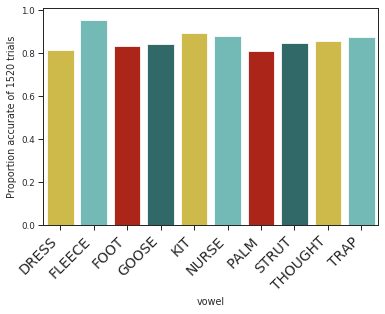

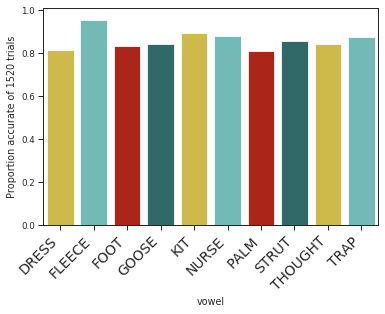

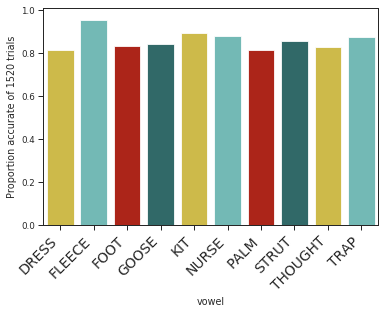

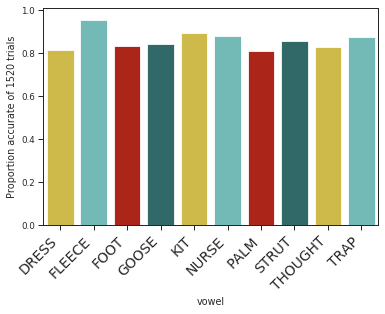

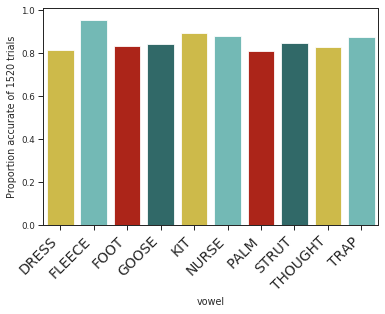

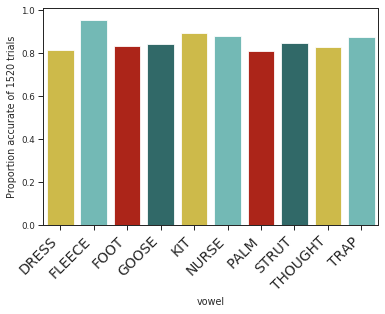

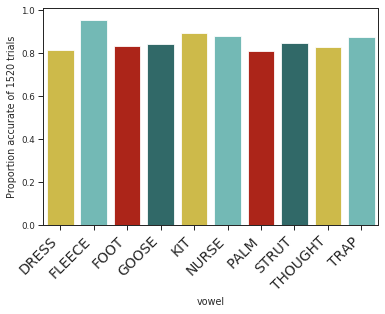

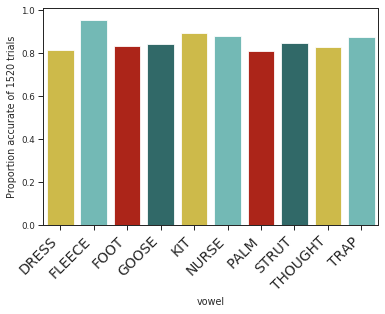

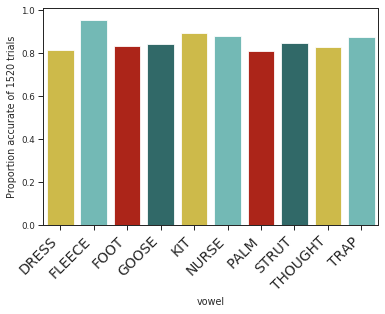

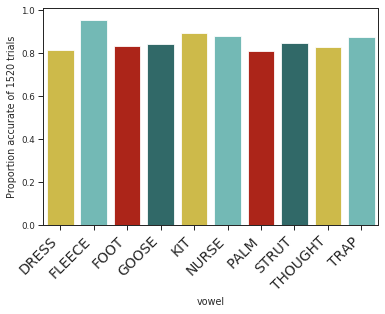

In [72]:
for q in pcdict.keys():
    accplot(pcdict[q],'vowel',accdict[q])

In [73]:
accdict

{'res0':       Unnamed: 0 type gender  speaker    vowel  repetition   F0    F1    F2  \
 0              0    m      m        1   FLEECE           1  160   240  2280   
 1              1    m      m        1   FLEECE           2  186   280  2400   
 2              2    m      m        1      KIT           1  203   390  2030   
 3              3    m      m        1      KIT           2  192   310  1980   
 4              4    m      m        1    DRESS           1  161   490  1870   
 5              5    m      m        1    DRESS           2  155   570  1700   
 6              6    m      m        1     TRAP           1  140   560  1820   
 7              7    m      m        1     TRAP           2  180   630  1700   
 8              8    m      m        1    STRUT           1  144   590  1250   
 9              9    m      m        1    STRUT           2  148   620  1300   
 10            10    m      m        1     PALM           1  148   740  1070   
 11            11    m      m   

In [ ]:
for dx in ch.keys():
    name='res'+str(dx)+'cyc.csv'
    ch[dx].to_csv(name)
    

In [ ]:
ch.to_csv("res_cycles_1.csv")

## scratch

In [ ]:
continuum ('TRAP','PALM',pbbark,['F0','F1','F2','F3'],steps=7,df=True)

# Parameter fitting